In [1]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
import os

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import andrews_curves, parallel_coordinates, radviz

# Машинное обучение (для нормализации)
from sklearn.preprocessing import MinMaxScaler
from math import pi

# Настройки
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

# Цветовая палитра для Nutri-Score
NUTRI_COLORS = {'A': '#038141', 'B': '#85BB2F', 'C': '#FECB02', 'D': '#EE8100', 'E': '#E63E11'}
NUTRI_COLORS_LIST = ['#038141', '#85BB2F', '#FECB02', '#EE8100', '#E63E11']

print("✓ Все библиотеки успешно импортированы!")
print("✓ Настройки визуализации применены!")
print("✓ Цветовая палитра Nutri-Score готова!")

✓ Все библиотеки успешно импортированы!
✓ Настройки визуализации применены!
✓ Цветовая палитра Nutri-Score готова!


## 1. Импорт библиотек

Импортируем все необходимые библиотеки для анализа и визуализации.

# Анализ датасета Open Food Facts - Полный проект

## 📊 Визуализация данных о пищевых продуктах

Этот блокнот содержит комплексный анализ датасета Open Food Facts с применением различных техник визуализации данных.

### Содержание:
1. **Загрузка и исследование данных**
2. **Очистка и предобработка**
3. **Базовая визуализация** (scatter, box, violin plots)
4. **Продвинутый анализ** (pair plots, корреляции)
5. **Многомерные техники** (Andrews curves, Parallel coordinates, RadViz)

---

**Датасет:** Open Food Facts (en.openfoodfacts.org.products.csv.gz)

## 2. Загрузка данных

Загружаем датасет Open Food Facts и изучаем его структуру.

In [3]:
# Проверяем наличие файла
file_gz = '../LEC_2_data_vis/en.openfoodfacts.org.products.csv.gz'
file_csv = '../LEC_2_data_vis/en.openfoodfacts.org.products.csv'

if os.path.exists(file_gz):
    file_path = file_gz
    print(f"✓ Найден файл: {file_gz}")
elif os.path.exists(file_csv):
    file_path = file_csv
    print(f"✓ Найден файл: {file_csv}")
else:
    print("❌ Файл не найден!")
    print("Пожалуйста, запустите download_openfoodfacts.py")
    raise FileNotFoundError("Dataset file not found")

# Определяем нужные столбцы
usecols = [
    'product_name', 'categories', 'countries',
    'energy_100g', 'proteins_100g', 'carbohydrates_100g',
    'fat_100g', 'sugars_100g', 'sodium_100g',
    'nutriscore_grade'
]

print(f"\n📊 Загрузка датасета...")
print("⏳ Это может занять 1-2 минуты...")

compression = 'gzip' if file_path.endswith('.gz') else None

try:
    # Попытка прямой загрузки (быстро, если хватает памяти)
    df = pd.read_csv(
        file_path,
        sep='\t',
        usecols=usecols,
        low_memory=False,
        compression=compression
    )
    print("\n✓ Датасет успешно загружен!")
    print(f"📏 Размер: {df.shape[0]:,} строк × {df.shape[1]} столбцов")
except (MemoryError, pd.errors.ParserError) as e:
    print(f"\n⚠️ Прямая загрузка не удалась: {e}")
    print("Читаем файл по частям (chunked) и формируем выборку, чтобы избежать переполнения памяти...")
    chunksize = 100000
    max_rows = 200000  # максимум строк для анализа/визуализации
    dfs = []
    rows = 0
    for chunk in pd.read_csv(file_path, sep='\t', usecols=usecols, compression=compression, chunksize=chunksize, iterator=True, dtype=str):
        dfs.append(chunk)
        rows += len(chunk)
        if rows >= max_rows:
            break
    df = pd.concat(dfs, ignore_index=True)
    # Если превысили max_rows, оставим случайную подвыборку
    if len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=42).reset_index(drop=True)
    print(f"\n✓ Загружено (chunked): {len(df):,} строк × {df.shape[1]} столбцов")

✓ Найден файл: ../LEC_2_data_vis/en.openfoodfacts.org.products.csv.gz

📊 Загрузка датасета...
⏳ Это может занять 1-2 минуты...

⚠️ Прямая загрузка не удалась: Error tokenizing data. C error: out of memory
Читаем файл по частям (chunked) и формируем выборку, чтобы избежать переполнения памяти...

⚠️ Прямая загрузка не удалась: Error tokenizing data. C error: out of memory
Читаем файл по частям (chunked) и формируем выборку, чтобы избежать переполнения памяти...

✓ Загружено (chunked): 200,000 строк × 10 столбцов

✓ Загружено (chunked): 200,000 строк × 10 столбцов


In [4]:
# Первые строки датасета
print("📋 Первые 5 строк:")
display(df.head())

print("\n📊 Информация о столбцах:")
df.info()

# Статистика пропущенных значений
print("\n❓ Пропущенные значения:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Пропущено': missing, 'Процент': missing_pct})
display(missing_df[missing_df['Пропущено'] > 0].sort_values('Пропущено', ascending=False))

📋 Первые 5 строк:


,product_name,categories,countries,nutriscore_grade,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,sodium_100g
0,Filets de poulet blanc x2,Protein powders,"Brasilien, Germany",not-applicable,392,2.7,0.9,6.2,30,0.16
1,NaN,NaN,en:France,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Entrecôesteack - Highland Beef,Nutrition drink mix,"Brasilien, Germany",d,2401,12,13,9,23,0.12
3,NaN,NaN,en:France,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Triple cheese puff,"Boissons et préparations de boissons, Boissons...","Germany, United States, en:france",c,1520,11,25,0.98,22,0.38



📊 Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   product_name        192097 non-null  object
 1   categories          109278 non-null  object
 2   countries           199132 non-null  object
 3   nutriscore_grade    199115 non-null  object
 4   energy_100g         166785 non-null  object
 5   fat_100g            165526 non-null  object
 6   carbohydrates_100g  166112 non-null  object
 7   sugars_100g         158194 non-null  object
 8   proteins_100g       165683 non-null  object
 9   sodium_100g         151254 non-null  object
dtypes: object(10)
memory usage: 15.3+ MB

❓ Пропущенные значения:


,Пропущено,Процент
categories,90722,45.36
sodium_100g,48746,24.37
sugars_100g,41806,20.90
fat_100g,34474,17.24
proteins_100g,34317,17.16
carbohydrates_100g,33888,16.94
energy_100g,33215,16.61
product_name,7903,3.95
nutriscore_grade,885,0.44
countries,868,0.43


## 3. Очистка данных

Выполняем предобработку: преобразование типов, удаление пропусков, фильтрация выбросов.

In [5]:
print("🧹 Начинаем очистку данных...\n")

df_clean = df.copy()
print(f"Исходный размер: {df_clean.shape[0]:,} строк")

# Преобразуем пищевые колонки в числа
nutrition_cols = ['energy_100g', 'proteins_100g', 'carbohydrates_100g', 
                  'fat_100g', 'sugars_100g', 'sodium_100g']

for col in nutrition_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print("✓ Преобразованы типы данных")

# Удаляем пропуски
df_clean = df_clean.dropna(subset=nutrition_cols, how='any')
print(f"✓ После удаления пропусков: {df_clean.shape[0]:,} строк")

# Фильтруем выбросы
df_clean = df_clean[(df_clean['energy_100g'] > 0) & (df_clean['energy_100g'] < 2000)]
print(f"✓ После фильтрации энергии: {df_clean.shape[0]:,} строк")

for col in ['proteins_100g', 'carbohydrates_100g', 'fat_100g']:
    df_clean = df_clean[(df_clean[col] >= 0) & (df_clean[col] <= 100)]
    
print(f"✓ После фильтрации макронутриентов: {df_clean.shape[0]:,} строк")

# Нормализуем Nutri-Score
df_clean['nutriscore_grade'] = df_clean['nutriscore_grade'].str.upper().str.strip()
df_clean = df_clean[df_clean['nutriscore_grade'].isin(['A', 'B', 'C', 'D', 'E'])]
print(f"✓ После фильтрации Nutri-Score: {df_clean.shape[0]:,} строк")

# Удаляем дубликаты
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.reset_index(drop=True)
print(f"✓ После удаления дубликатов: {df_clean.shape[0]:,} строк")

print(f"\n📊 Итого сохранено: {(df_clean.shape[0]/df.shape[0]*100):.1f}% данных")
print("\n✓ Очистка завершена!")

🧹 Начинаем очистку данных...

Исходный размер: 200,000 строк
✓ Преобразованы типы данных
✓ После удаления пропусков: 144,541 строк
✓ После фильтрации энергии: 110,240 строк
✓ После фильтрации макронутриентов: 109,980 строк
✓ После фильтрации Nutri-Score: 67,574 строк
✓ После удаления дубликатов: 63,684 строк

📊 Итого сохранено: 31.8% данных

✓ Очистка завершена!
✓ После фильтрации Nutri-Score: 67,574 строк
✓ После удаления дубликатов: 63,684 строк

📊 Итого сохранено: 31.8% данных

✓ Очистка завершена!


In [6]:
# Распределение Nutri-Score
print("🎯 Распределение Nutri-Score:")
nutri_counts = df_clean['nutriscore_grade'].value_counts().sort_index()
display(nutri_counts)

print("\n📈 Статистика по питательным веществам:")
display(df_clean[nutrition_cols].describe())

🎯 Распределение Nutri-Score:


nutriscore_grade
A    13147
B     6878
C    12169
D    15574
E    15916
Name: count, dtype: int64


📈 Статистика по питательным веществам:


,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,sodium_100g
count,63684.000000,63684.000000,63684.000000,63684.000000,63684.000000,63684.000000
mean,911.632255,6.684863,32.041090,7.335696,14.236128,0.652939
std,611.725325,8.186698,29.190938,9.262017,19.074402,15.480969
min,0.282000,0.000000,0.000000,0.000000,-1.450000,0.000000
25%,297.000000,0.830000,7.080000,0.000000,1.600000,0.004050
50%,895.000000,4.080000,18.750000,3.210000,5.290000,0.179000
75%,1494.000000,9.410000,60.000000,12.000000,20.900000,0.474000
max,1997.000000,100.000000,100.000000,100.000000,233.000000,2030.000000


## 4. Базовая визуализация

### 4.1 Scatter Plots - Энергия vs Белки

Исследуем взаимосвязь между энергетической ценностью и содержанием белка.

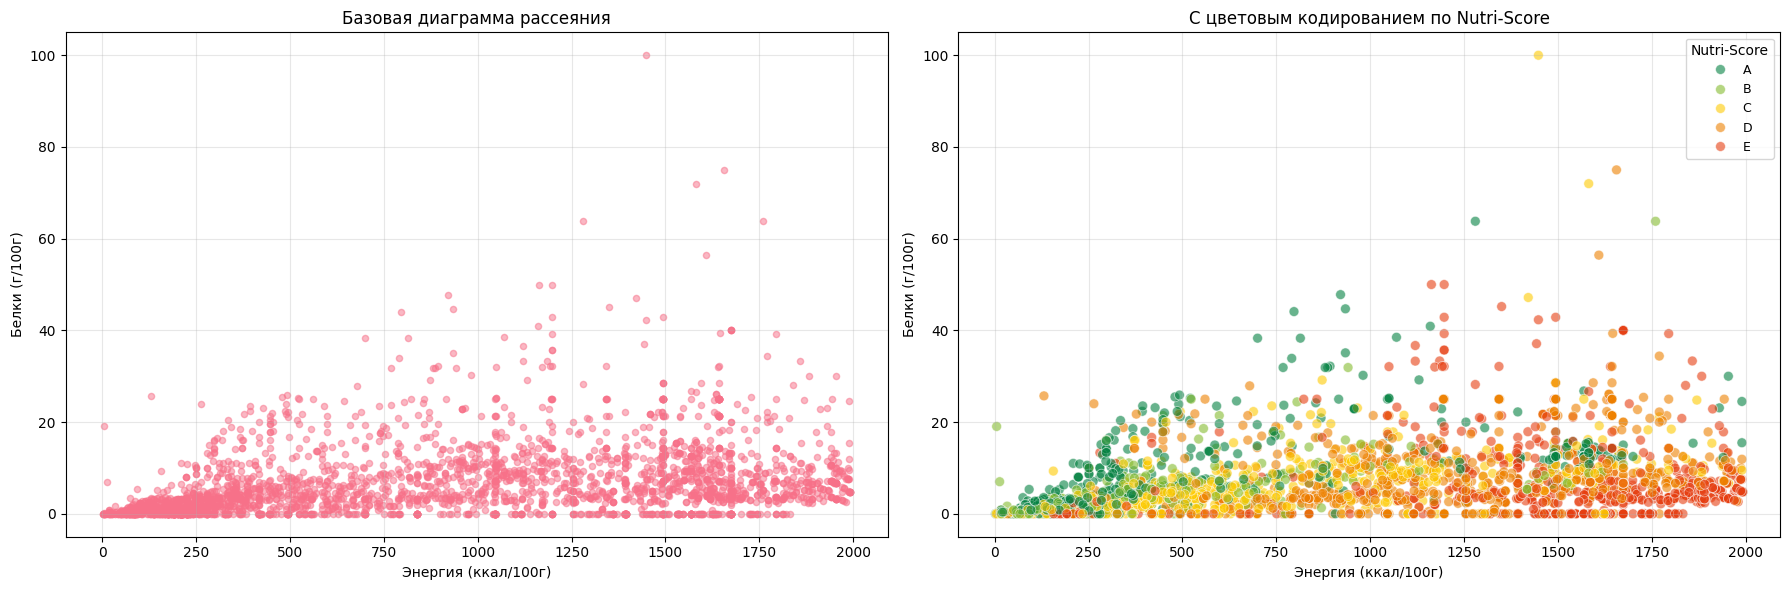

💡 Выводы:
   • Положительная корреляция между энергией и белком
   • Nutri-Score 'A' и 'B' имеют лучшее соотношение белок/энергия


In [7]:
# Берём выборку для визуализации
df_sample = df_clean.sample(n=min(3000, len(df_clean)), random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Базовая диаграмма
df_sample.plot.scatter(x='energy_100g', y='proteins_100g', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Энергия (ккал/100г)')
axes[0].set_ylabel('Белки (г/100г)')
axes[0].set_title('Базовая диаграмма рассеяния')
axes[0].grid(True, alpha=0.3)

# 2. С цветовым кодированием
sns.scatterplot(
    data=df_sample,
    x='energy_100g',
    y='proteins_100g',
    hue='nutriscore_grade',
    palette=NUTRI_COLORS,
    hue_order=['A', 'B', 'C', 'D', 'E'],
    alpha=0.6,
    s=50,
    ax=axes[1]
)
axes[1].set_xlabel('Энергия (ккал/100г)')
axes[1].set_ylabel('Белки (г/100г)')
axes[1].set_title('С цветовым кодированием по Nutri-Score')
axes[1].legend(title='Nutri-Score', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Выводы:")
print("   • Положительная корреляция между энергией и белком")
print("   • Nutri-Score 'A' и 'B' имеют лучшее соотношение белок/энергия")

### 4.2 Box Plots - Распределение по Nutri-Score

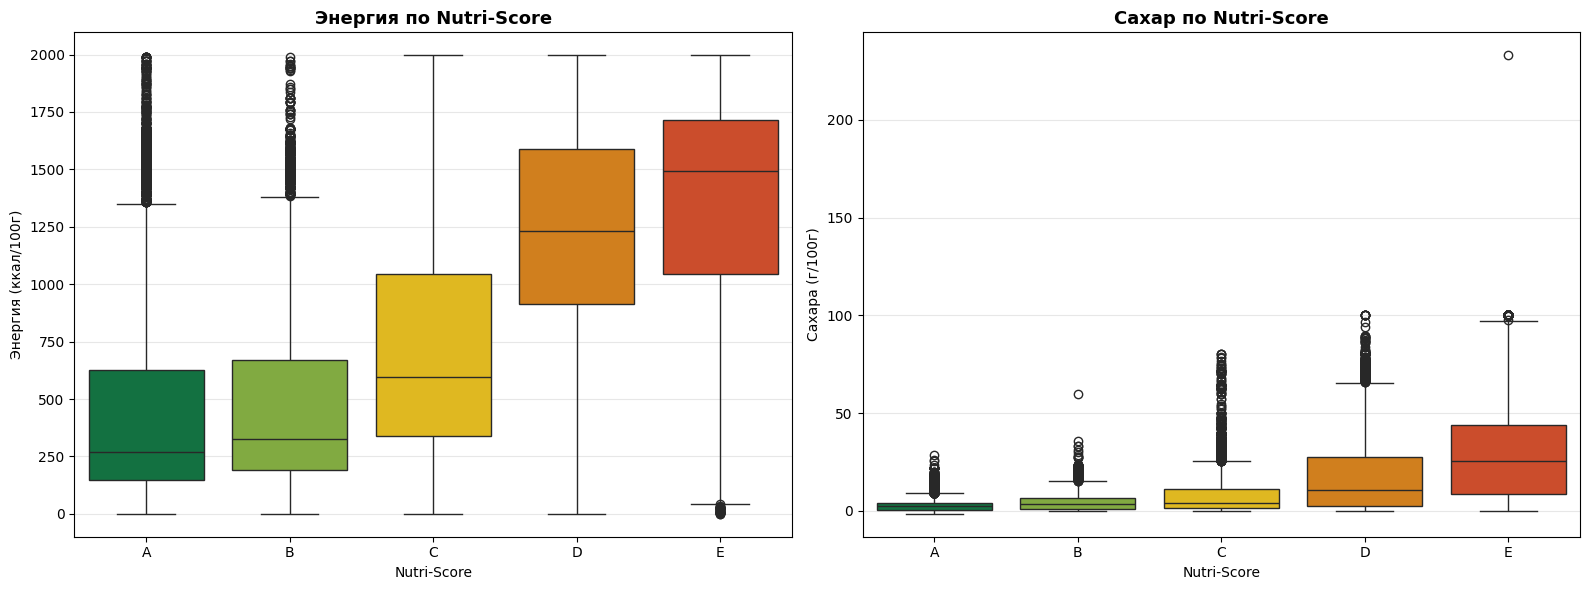

📊 Средние значения по Nutri-Score:


,energy_100g,proteins_100g,sugars_100g,fat_100g
nutriscore_grade,,,,
A,494.32,7.10,3.10,1.86
B,484.38,5.01,4.58,2.59
C,714.40,5.67,7.80,5.31
D,1202.80,8.55,17.67,11.31
E,1306.87,6.02,29.17,11.57


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Энергия
sns.boxplot(data=df_clean, x='nutriscore_grade', y='energy_100g',
            order=['A', 'B', 'C', 'D', 'E'], palette=NUTRI_COLORS_LIST, ax=ax1)
ax1.set_title('Энергия по Nutri-Score', fontsize=13, fontweight='bold')
ax1.set_xlabel('Nutri-Score')
ax1.set_ylabel('Энергия (ккал/100г)')
ax1.grid(True, alpha=0.3, axis='y')

# Сахар
sns.boxplot(data=df_clean, x='nutriscore_grade', y='sugars_100g',
            order=['A', 'B', 'C', 'D', 'E'], palette=NUTRI_COLORS_LIST, ax=ax2)
ax2.set_title('Сахар по Nutri-Score', fontsize=13, fontweight='bold')
ax2.set_xlabel('Nutri-Score')
ax2.set_ylabel('Сахара (г/100г)')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Средние значения
print("📊 Средние значения по Nutri-Score:")
display(df_clean.groupby('nutriscore_grade')[
    ['energy_100g', 'proteins_100g', 'sugars_100g', 'fat_100g']
].mean().round(2))

### 4.3 Violin Plots и KDE

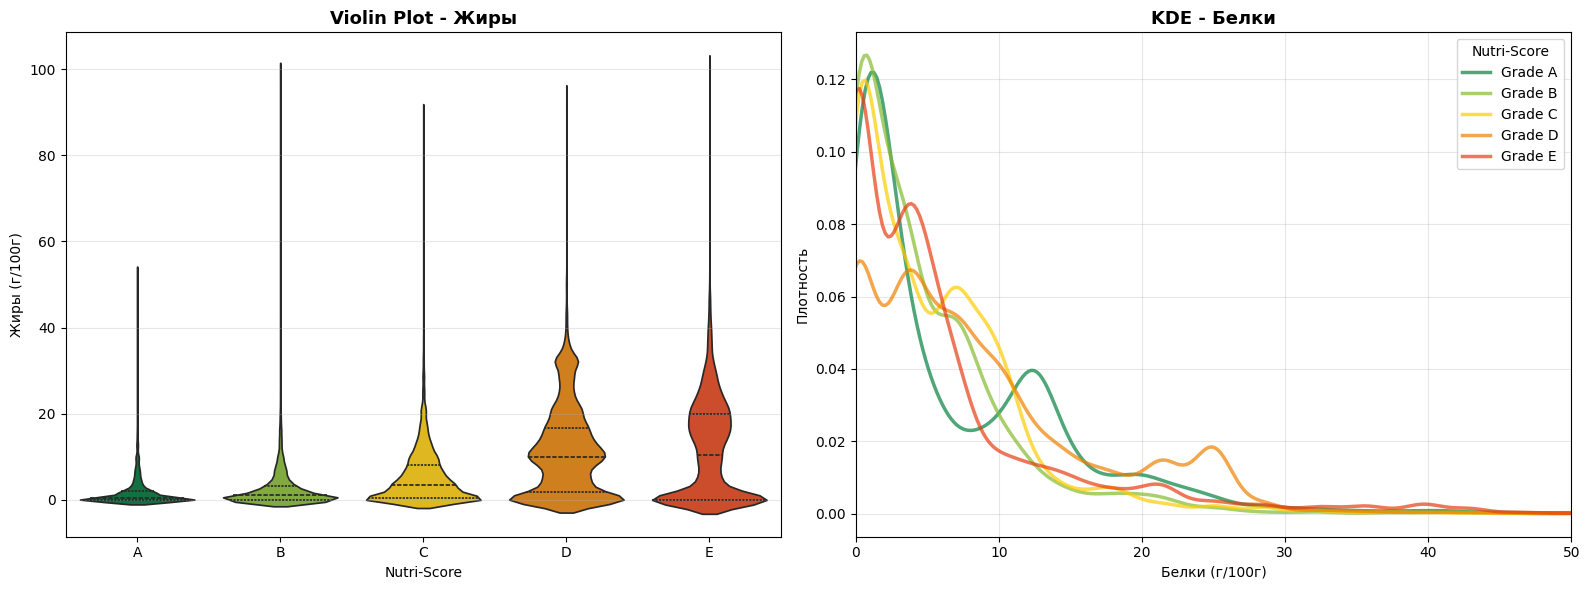

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Violin plot для жиров
sns.violinplot(data=df_clean, x='nutriscore_grade', y='fat_100g',
               order=['A', 'B', 'C', 'D', 'E'], palette=NUTRI_COLORS_LIST, 
               inner='quartile', ax=ax1)
ax1.set_title('Violin Plot - Жиры', fontsize=13, fontweight='bold')
ax1.set_xlabel('Nutri-Score')
ax1.set_ylabel('Жиры (г/100г)')
ax1.grid(True, alpha=0.3, axis='y')

# KDE для белка
for grade in ['A', 'B', 'C', 'D', 'E']:
    grade_data = df_clean[df_clean['nutriscore_grade'] == grade]['proteins_100g']
    grade_data.plot.kde(ax=ax2, label=f'Grade {grade}', color=NUTRI_COLORS[grade], linewidth=2.5, alpha=0.7)

ax2.set_title('KDE - Белки', fontsize=13, fontweight='bold')
ax2.set_xlabel('Белки (г/100г)')
ax2.set_ylabel('Плотность')
ax2.legend(title='Nutri-Score')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 50)

plt.tight_layout()
plt.show()

## 5. Продвинутый анализ

### 5.1 Pair Plots и Корреляции

⏳ Создание pair plot (может занять минуту)...


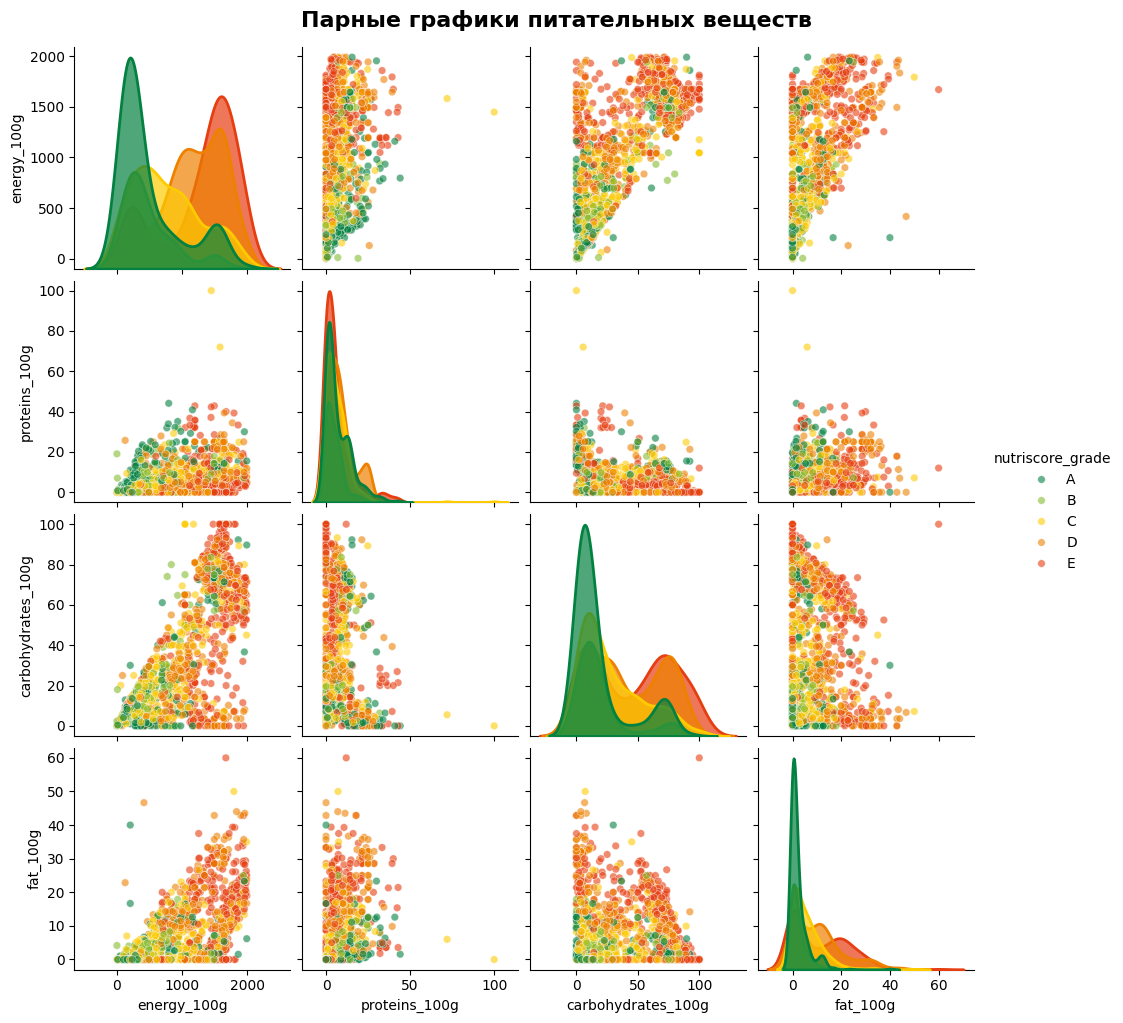

✓ Pair plot создан!


In [10]:
print("⏳ Создание pair plot (может занять минуту)...")

df_pairplot = df_clean.sample(n=min(1500, len(df_clean)), random_state=42)
nutrients_for_pairplot = ['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g', 'nutriscore_grade']

pairplot = sns.pairplot(
    df_pairplot[nutrients_for_pairplot],
    hue='nutriscore_grade',
    palette=NUTRI_COLORS,
    hue_order=['A', 'B', 'C', 'D', 'E'],
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 30},
    diag_kws={'alpha': 0.7, 'linewidth': 2},
    height=2.5
)
pairplot.fig.suptitle('Парные графики питательных веществ', y=1.02, fontsize=16, fontweight='bold')
plt.show()

print("✓ Pair plot создан!")

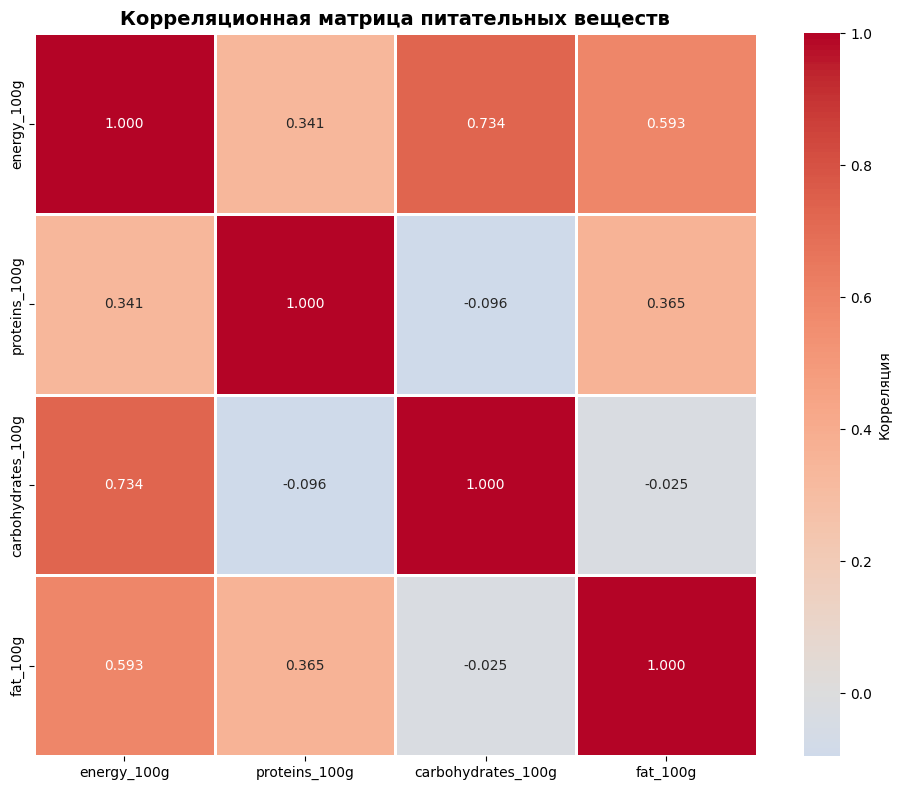


📊 Корреляционная матрица:


,energy_100g,proteins_100g,carbohydrates_100g,fat_100g
energy_100g,1.000,0.341,0.734,0.593
proteins_100g,0.341,1.000,-0.096,0.365
carbohydrates_100g,0.734,-0.096,1.000,-0.025
fat_100g,0.593,0.365,-0.025,1.000


In [11]:
# Корреляционная матрица
correlation_matrix = df_clean[['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g']].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Корреляция'}, ax=ax)
ax.set_title('Корреляционная матрица питательных веществ', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Корреляционная матрица:")
display(correlation_matrix.round(3))

### 5.2 Продвинутые многомерные техники

Andrews Curves, Parallel Coordinates, RadViz, Radar Chart

In [12]:
# Подготовка данных - нормализация
df_advanced = df_clean.sample(n=min(1000, len(df_clean)), random_state=42).copy()
nutrients = ['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g']

scaler = MinMaxScaler()
df_advanced[nutrients] = scaler.fit_transform(df_advanced[nutrients])
df_advanced = df_advanced.sort_values('nutriscore_grade')

print("✓ Данные подготовлены и нормализованы")

✓ Данные подготовлены и нормализованы


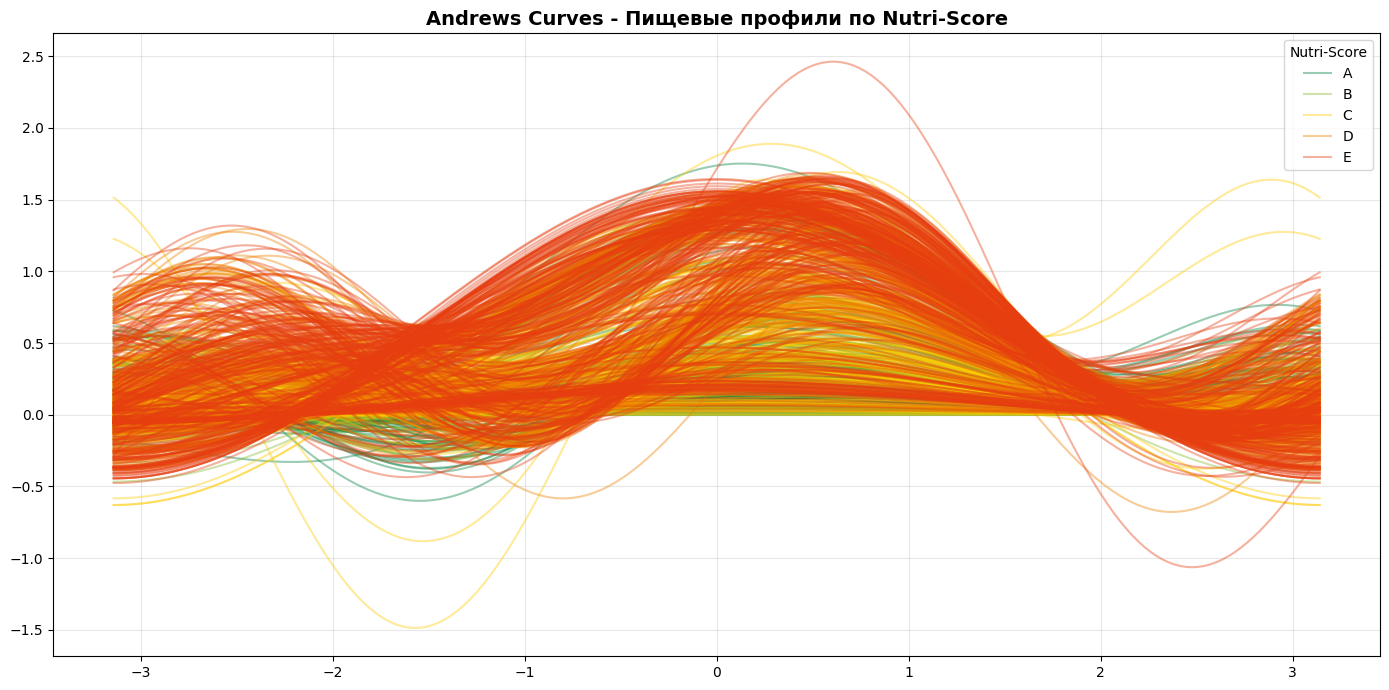

In [13]:
# Andrews Curves
fig, ax = plt.subplots(figsize=(14, 7))
andrews_curves(
    df_advanced[nutrients + ['nutriscore_grade']],
    'nutriscore_grade',
    color=[NUTRI_COLORS[g] for g in ['A', 'B', 'C', 'D', 'E']],
    alpha=0.4,
    ax=ax
)
ax.set_title('Andrews Curves - Пищевые профили по Nutri-Score', fontsize=14, fontweight='bold')
ax.legend(title='Nutri-Score', loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

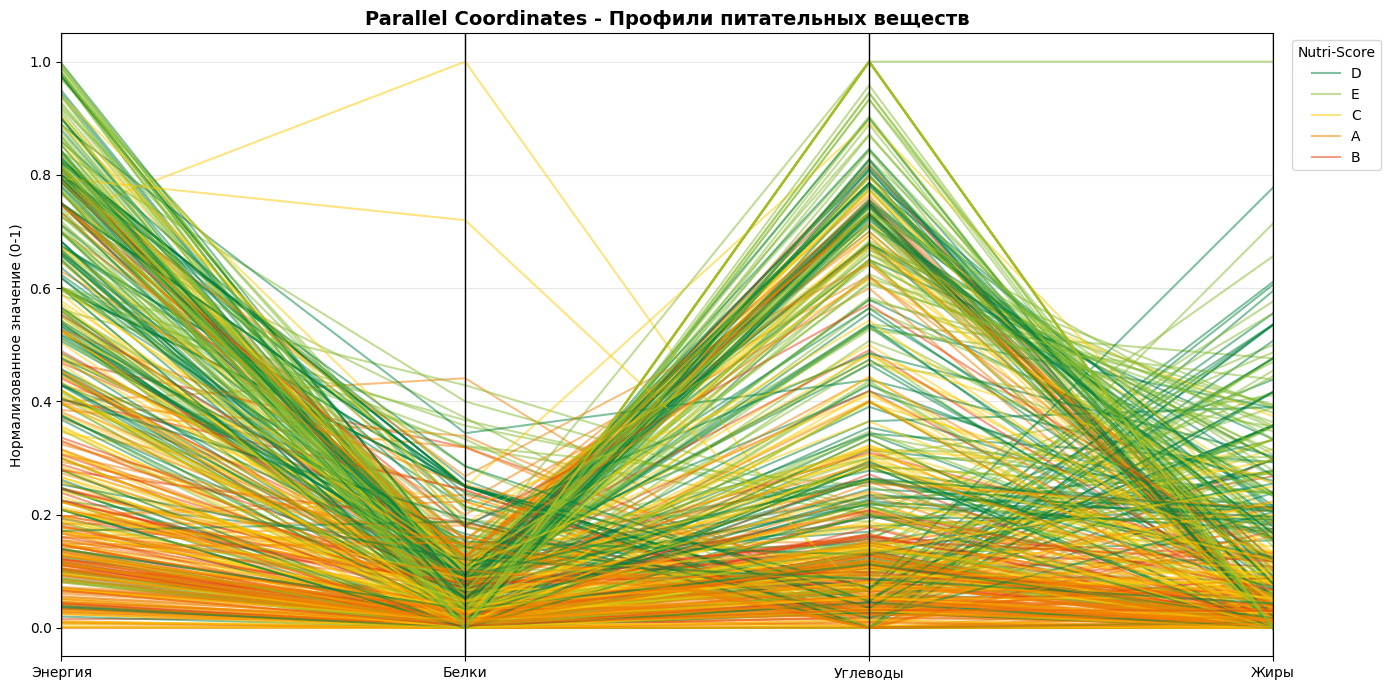

In [14]:
# Parallel Coordinates
df_parallel = df_advanced.sample(n=min(500, len(df_advanced)), random_state=42)

fig, ax = plt.subplots(figsize=(14, 7))
parallel_coordinates(
    df_parallel[nutrients + ['nutriscore_grade']],
    'nutriscore_grade',
    color=[NUTRI_COLORS[g] for g in ['A', 'B', 'C', 'D', 'E']],
    alpha=0.5,
    ax=ax
)
ax.set_title('Parallel Coordinates - Профили питательных веществ', fontsize=14, fontweight='bold')
ax.set_ylabel('Нормализованное значение (0-1)')
ax.legend(title='Nutri-Score', loc='upper left', bbox_to_anchor=(1.01, 1))
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(['Энергия', 'Белки', 'Углеводы', 'Жиры'])
plt.tight_layout()
plt.show()

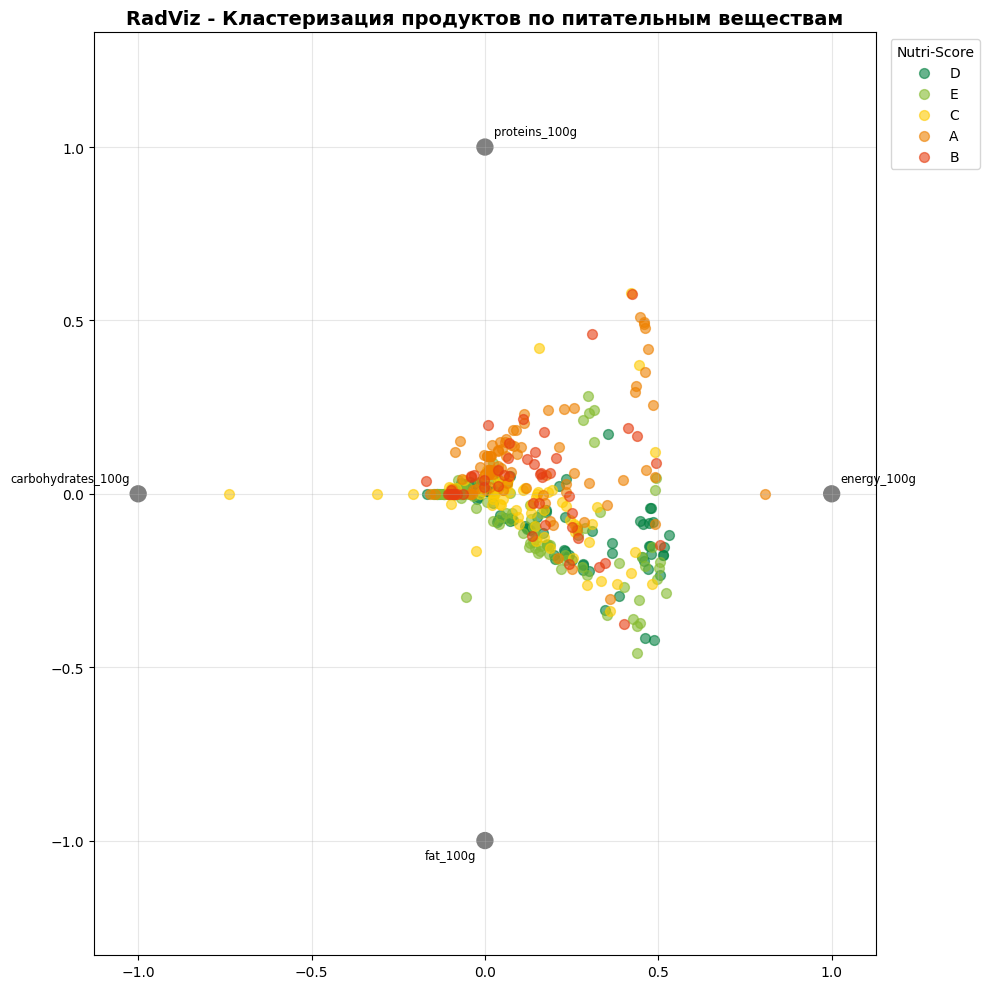

In [15]:
# RadViz
df_radviz = df_advanced.sample(n=min(400, len(df_advanced)), random_state=42)

fig, ax = plt.subplots(figsize=(10, 10))
radviz(
    df_radviz[nutrients + ['nutriscore_grade']],
    'nutriscore_grade',
    color=[NUTRI_COLORS[g] for g in ['A', 'B', 'C', 'D', 'E']],
    alpha=0.6,
    s=50,
    ax=ax
)
ax.set_title('RadViz - Кластеризация продуктов по питательным веществам', fontsize=14, fontweight='bold')
ax.legend(title='Nutri-Score', loc='upper left', bbox_to_anchor=(1.01, 1))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

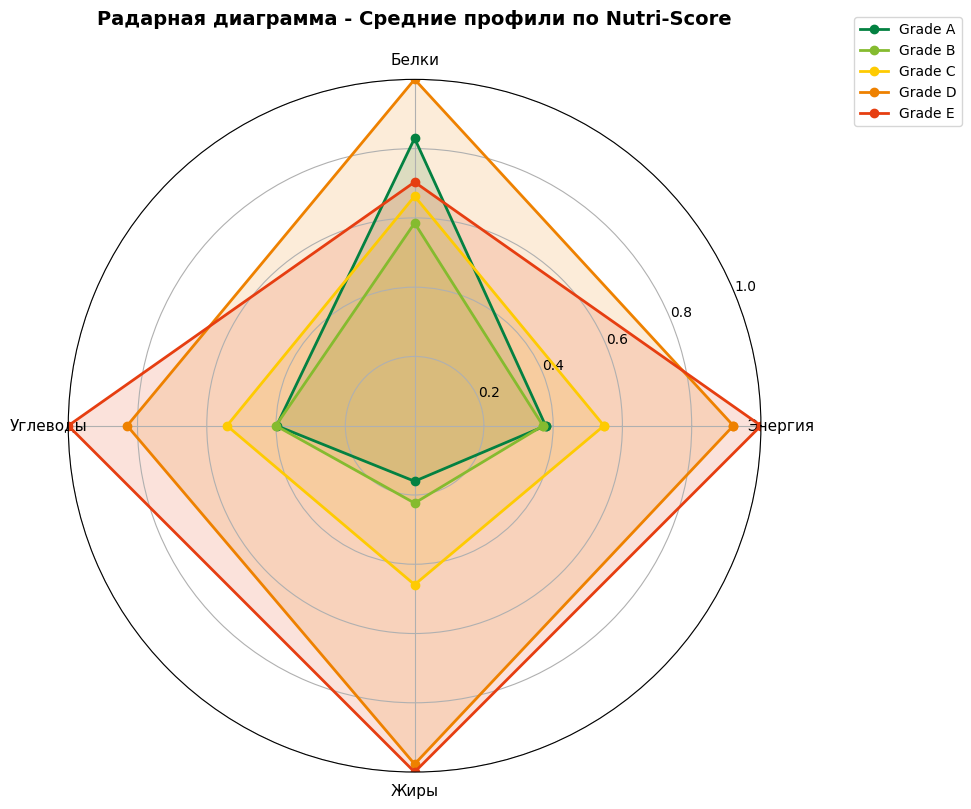


📊 Средние значения по Nutri-Score:


,energy_100g,proteins_100g,carbohydrates_100g,fat_100g
nutriscore_grade,,,,
A,494.32,7.10,18.72,1.86
B,484.38,5.01,18.83,2.59
C,714.40,5.67,25.45,5.31
D,1202.80,8.55,39.00,11.31
E,1306.87,6.02,46.98,11.57


In [16]:
# Radar Chart - Средние профили
mean_profiles = df_clean.groupby('nutriscore_grade')[
    ['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g']
].mean()

mean_profiles_norm = mean_profiles.copy()
for col in mean_profiles.columns:
    max_val = mean_profiles[col].max()
    if max_val > 0:
        mean_profiles_norm[col] = mean_profiles[col] / max_val

categories = ['Энергия', 'Белки', 'Углеводы', 'Жиры']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for grade in ['A', 'B', 'C', 'D', 'E']:
    values = mean_profiles_norm.loc[grade].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Grade {grade}', color=NUTRI_COLORS[grade])
    ax.fill(angles, values, alpha=0.15, color=NUTRI_COLORS[grade])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Радарная диаграмма - Средние профили по Nutri-Score', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)
plt.tight_layout()
plt.show()

print("\n📊 Средние значения по Nutri-Score:")
display(mean_profiles.round(2))

## 6. Выводы

### Ключевые находки:

1. **Энергия и питательные вещества**
   - Сильная корреляция между энергией и жирами
   - Продукты с Nutri-Score 'A' имеют более низкую энергетическую ценность
   - Продукты с оценкой 'E' содержат значительно больше сахара

2. **Распределения**
   - Продукты категории 'A' имеют более узкие распределения (меньше вариативности)
   - Категории 'D' и 'E' показывают широкие распределения с выбросами

3. **Многомерный анализ**
   - Pair plots выявляют чёткие кластеры по Nutri-Score
   - Andrews Curves и RadViz подтверждают различия в пищевых профилях
   - Parallel Coordinates показывают градиент от 'A' (сбалансированные) до 'E' (несбалансированные)

### Рекомендации:
- Использовать Nutri-Score как надёжный индикатор пищевой ценности
- Продукты с оценкой 'A' и 'B' предпочтительны для здорового питания
- Обращать внимание на содержание сахара при выборе продуктов категории 'D' и 'E'

---

✅ **Анализ завершён!**